# Vision Transformers vs. CNN on CIFAR-10

## Training for VIT

In [2]:
# Install required package
!pip install timm --quiet

In [1]:
# Import packages
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
import timm
import time
import matplotlib.pyplot as plt
import tqdm
import copy

d:\Software\Anaconda3\envs\PythonAndR\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load and preprocess CIFAR-10

In [3]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


## Define training and evaluation utilities

In [4]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(train_loader), 100 * correct / total

def evaluate(model, test_loader, device, criterion):
    model.eval()
    correct, total = 0, 0
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(test_loader)
    return accuracy, avg_loss

## Train ViT

In [ ]:
# Load ViT Tiny
vit = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=10)
vit = vit.to(device)

# Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vit.parameters(), lr=1e-4)

# Train with early stopping (patience=2, max 20 epochs)
epochs = 20
best_acc = 0.0
patience = 2
wait = 0
best_model = copy.deepcopy(vit.state_dict())
train_accs, test_accs = [], []
train_losses, test_losses = [], []

for epoch in range(epochs):
    vit.train()
    running_loss, correct, total = 0.0, 0, 0

    loop = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vit(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        acc = 100 * correct / total
        loop.set_postfix(loss=loss.item(), acc=acc)

    train_acc = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader)
    train_accs.append(train_acc)
    train_losses.append(avg_train_loss)

    test_acc, avg_test_loss = evaluate(vit, test_loader, device,criterion)
    test_accs.append(test_acc)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}%, Test Acc={test_acc:.2f}%, "
          f"Train Loss={avg_train_loss:.4f}, Test Loss={avg_test_loss:.4f}")

    if test_acc > best_acc:
        best_acc = test_acc
        best_model = copy.deepcopy(vit.state_dict())
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

# 6. Save Best Model
torch.save(best_model, "vit_cifar10.pth")
print(f"Best Test Accuracy: {best_acc:.2f}%")


Epoch 1: Train Acc=92.16%, Test Acc=94.87%, Train Loss=0.2317, Test Loss=0.1484


Epoch 2: Train Acc=97.06%, Test Acc=94.69%, Train Loss=0.0866, Test Loss=0.1576


Epoch 3: Train Acc=97.86%, Test Acc=95.64%, Train Loss=0.0622, Test Loss=0.1435


Epoch 4: Train Acc=98.36%, Test Acc=94.72%, Train Loss=0.0463, Test Loss=0.1793


Epoch 5: Train Acc=98.49%, Test Acc=95.35%, Train Loss=0.0460, Test Loss=0.1615
Early stopping triggered at epoch 5.
Best Test Accuracy: 95.64%


## Plot and Compare

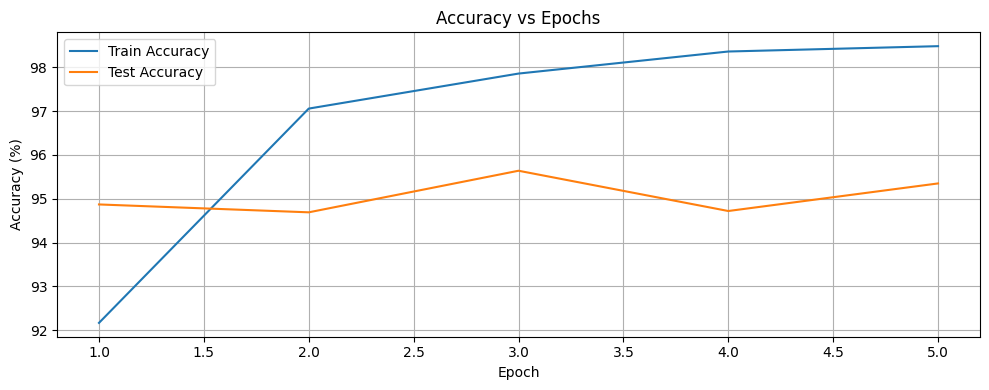

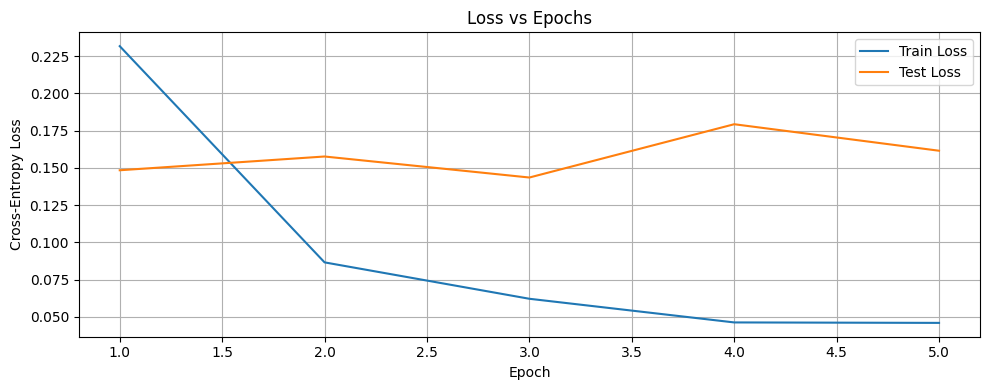

Saved: accuracy_plot.png, loss_plot.png, training_stats.pkl


In [ ]:
import matplotlib.pyplot as plt
import pickle

# Define epochs based on available training data
epochs = list(range(1, len(train_accs) + 1))

# 1. Accuracy Plot
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, test_accs, label='Test Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
acc_path = "accuracy_plot.png"
plt.savefig(acc_path)
plt.show()  # Show in notebook
plt.close()

# 2. Loss Plot
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
loss_path = "loss_plot.png"
plt.savefig(loss_path)
plt.show()  # Show in notebook
plt.close()

# 3. Save training statistics to dictionary
training_stats = {
    "epochs": epochs,
    "train_accs": train_accs,
    "test_accs": test_accs,
    "train_losses": train_losses,
    "test_losses": test_losses
}

stats_path = "training_stats.pkl"
with open(stats_path, "wb") as f:
    pickle.dump(training_stats, f)

print(f"Saved: {acc_path}, {loss_path}, {stats_path}")


The baseline ViT Tiny model was trained using the Adam optimizer with a learning rate of 1e-4. It achieved a best test accuracy of 95.64% at epoch 3. Training accuracy increased from 92.16% to 98.49%, and the training loss dropped significantly. However, validation (test) accuracy fluctuated across epochs — peaking early and slightly declining afterwards. Early stopping was triggered at epoch 5, which helped prevent overfitting as the test loss had started to increase. Overall, the baseline model trained well and reached strong generalization, but showed some instability and noise in test accuracy.

## Tunning 

In [5]:
vit = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=10)
vit = vit.to(device)

# Use AdamW with tuned LR and weight decay
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(vit.parameters(), lr=5e-5, weight_decay=1e-4)

# Training with early stopping
epochs = 20
best_acc = 0.0
patience = 2
wait = 0
best_model = copy.deepcopy(vit.state_dict())
train_accs, test_accs = [], []
train_losses, test_losses = [], []

for epoch in range(epochs):
    vit.train()
    running_loss, correct, total = 0.0, 0, 0

    loop = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vit(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
        acc = 100 * correct / total
        loop.set_postfix(loss=loss.item(), acc=acc)

    train_acc = 100 * correct / total
    avg_train_loss = running_loss / len(train_loader)
    train_accs.append(train_acc)
    train_losses.append(avg_train_loss)

    test_acc, avg_test_loss = evaluate(vit, test_loader, device, criterion)
    test_accs.append(test_acc)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.2f}%, Test Acc={test_acc:.2f}%, "
          f"Train Loss={avg_train_loss:.4f}, Test Loss={avg_test_loss:.4f}")

    if test_acc > best_acc:
        best_acc = test_acc
        best_model = copy.deepcopy(vit.state_dict())
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}.")
            break

Epoch 1: Train Acc=92.57%, Test Acc=95.30%, Train Loss=0.2251, Test Loss=0.1395


Epoch 2: Train Acc=97.89%, Test Acc=95.88%, Train Loss=0.0628, Test Loss=0.1229


Epoch 3: Train Acc=98.86%, Test Acc=95.86%, Train Loss=0.0350, Test Loss=0.1400


Epoch 4: Train Acc=99.14%, Test Acc=96.20%, Train Loss=0.0258, Test Loss=0.1258


Epoch 5: Train Acc=99.25%, Test Acc=95.56%, Train Loss=0.0229, Test Loss=0.1741


Epoch 6: Train Acc=99.31%, Test Acc=96.31%, Train Loss=0.0219, Test Loss=0.1419


Epoch 7: Train Acc=99.37%, Test Acc=96.07%, Train Loss=0.0198, Test Loss=0.1450


Epoch 8: Train Acc=99.36%, Test Acc=96.18%, Train Loss=0.0194, Test Loss=0.1436
Early stopping triggered at epoch 8.


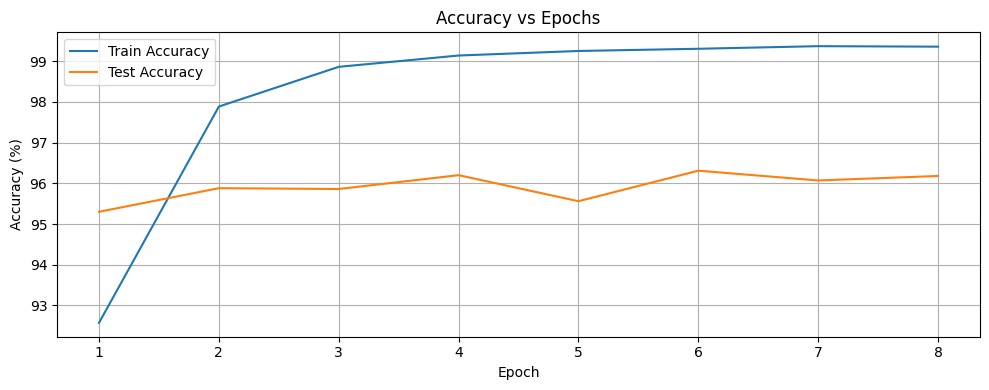

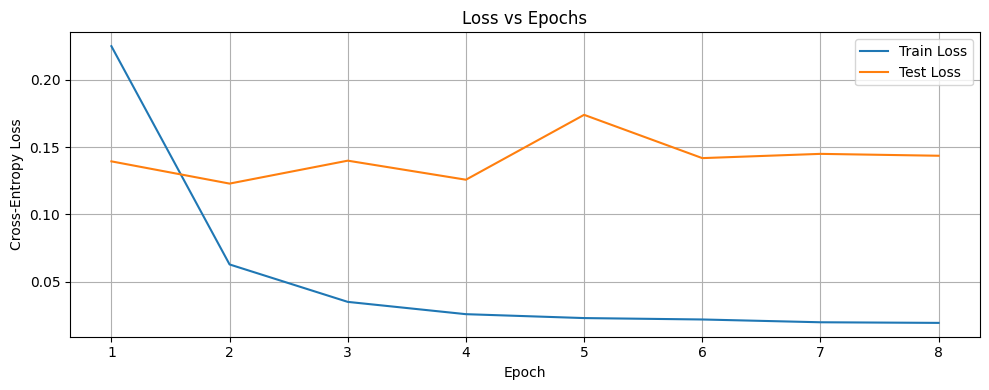

In [7]:
# Define epochs based on available training data
epochs = list(range(1, len(train_accs) + 1))

# 1. Accuracy Plot
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, test_accs, label='Test Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
acc_path = "accuracy_plot.png"
plt.savefig(acc_path)
plt.show()  # Show in notebook
plt.close()

# 2. Loss Plot
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
loss_path = "loss_plot.png"
plt.savefig(loss_path)
plt.show()  # Show in notebook
plt.close()




After tuning, the ViT Tiny model was trained with AdamW optimizer, a lower learning rate of 5e-5, and weight decay of 1e-4. This configuration provided more stable training and better generalization. The model achieved a peak test accuracy of 96.31% at epoch 6 — an improvement over the baseline. Training accuracy reached 99.37%, and both train and test loss consistently dropped in the first few epochs. The early stopping mechanism was triggered at epoch 8 after performance plateaued. These results show that tuning enhanced both stability and accuracy, allowing the model to generalize better without overfitting.

| Aspect               | Baseline ViT Tiny           | Tuned ViT Tiny               |
|----------------------|-----------------------------|-------------------------------|
| **Optimizer**        | Adam                        | AdamW                         |
| **Learning Rate**    | 1e-4                        | 5e-5                          |
| **Weight Decay**     | None                        | 1e-4                          |
| **Early Stop Epoch** | 5                           | 8                             |
| **Best Test Accuracy** | 95.64%                   |   96.31%                       |
| **Final Train Accuracy** | 98.49%                | 99.37%                        |
| **Stability**        | Moderate (fluctuating)      | High (consistent improvement) |
| **Overfitting Risk** | Mild signs post-epoch 3     | Well-controlled               |
